<a href="https://colab.research.google.com/github/sleepyMS/Ai-Smart-Cook/blob/main/2024_01_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## LSTM 사용을 위한 학습 - 1

In [ ]:
# !pip3 install ccxt

In [ ]:
# import ccxt
import time
import pandas as pd
import numpy as np
import pprint
import datetime
import matplotlib.pyplot as plt

In [ ]:
df1 = pd.read_csv('./CRYPTOCAP_BTC.D, 1D.csv')
df2 = pd.read_csv('./BINANCE_BTCUSDT, 1D.csv')
df3 = pd.read_csv('./BINANCE_XRPUSDT, 1D.csv')

df1 = df1.iloc[:,[0,4]]
df2 = df2.iloc[:,[0,4]]
df3 = df3.iloc[:,[0,4]]

df = pd.merge(df1, df2, on='time')
data = pd.merge(df, df3, on='time')
data = data.set_index('time')

data

,close_x,close_y,close
time,,,
2020-01-01,69.921538,7200.85,0.19305
2020-01-02,69.920361,6965.71,0.18750
2020-01-03,69.955510,7344.96,0.19338
2020-01-04,69.875262,7354.11,0.19305
2020-01-05,69.704416,7358.75,0.19453
...,...,...,...
2023-12-27,51.475842,43428.85,0.63400
2023-12-28,51.340381,42563.76,0.63460
2023-12-29,51.282270,42066.95,0.62300


## Min max scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)

# scaler = MinMaxScaler()
# scaler.fit(data2)
# scaled_data2 = scaler.transform(data2)

In [ ]:
# combined_array = np.concatenate((scaled_data, scaled_data2), axis=1)

x = scaled_data[:, [0,1, 2]].copy()
y = scaled_data[:, 2].copy()

In [ ]:
x.shape, y.shape, x

((1461, 3),
 (1461,),
 array([[0.9213695 , 0.0382753 , 0.03387496],
        [0.92133442, 0.03452661, 0.0306087 ],
        [0.92238209, 0.04057276, 0.03406917],
        ...,
        [0.36579819, 0.59412446, 0.28690729],
        [0.36884987, 0.59529352, 0.28555371],
        [0.37511109, 0.59757806, 0.28255227]]))

## Batch data 제작

In [ ]:
timestemps = 32

In [ ]:
x_seq = []
y_seq = []

for i in range(len(y)-timestemps):
  x_seq.append(x[i:i+timestemps, :])
  y_seq.append(y[i+timestemps])

In [ ]:
len(x_seq), len(y_seq)

(1429, 1429)

In [ ]:
x_seq = np.array(x_seq)
y_seq = np.array(y_seq)

In [ ]:
train_size = int(len(x_seq) * 0.6)
val_size = int(len(y_seq) * 0.2)

train_size, val_size

(857, 285)

In [ ]:
x_train = x_seq[:train_size].copy()
x_val = x_seq[train_size:train_size+val_size].copy()
x_test = x_seq[train_size+val_size:].copy()

y_train = y_seq[:train_size].copy()
y_val = y_seq[train_size:train_size+val_size].copy()
y_test = y_seq[train_size+val_size:].copy()

# x_val = x_seq[:val_size].copy()
# x_train = x_seq[val_size:train_size+val_size].copy()
# x_test = x_seq[train_size+val_size:].copy()

# y_val = y_seq[:val_size].copy()
# y_train = y_seq[val_size:train_size+val_size].copy()
# y_test = y_seq[train_size+val_size:].copy()

# result_data = np.array(data2.iloc[:,3])[timestemps:]
# result_data = result_data[train_size+val_size:].copy()

# result_value = np.array(data2.iloc[:,4])[timestemps:]
# result_value = result_value[train_size+val_size:].copy()


In [ ]:
# x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

## AI Modeling with LSTM

In [ ]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse, MeanSquaredError, huber, mae
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

from scipy.stats import pearsonr

In [ ]:
clear_session()

model = Sequential([
    LSTM(256, input_shape = x_seq[0].shape, return_sequences=True),
    Dropout(0.2),
    # BatchNormalization(),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    # BatchNormalization(),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    # BatchNormalization(),
    Dense(32, activation = 'relu'),
    Dropout(0.2),
    Dense(1)
])

opt = Adam(learning_rate=0.001)
loss = mse

model.compile(loss = loss, optimizer = opt, metrics = ['mse'])
model.summary()

# 조기 종료 콜백 생성
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델 훈련 시 콜백 추가
model.fit(x_train, y_train, batch_size = 32, epochs=100, verbose=1, validation_data=(x_val, y_val), callbacks=[early_stopping])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32, 256)           266240    
                                                                 
 dropout (Dropout)           (None, 32, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 32, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 32, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2

In [ ]:
y_pred = model.predict(x_test)

9/9 [==============================] - 1s 4ms/step


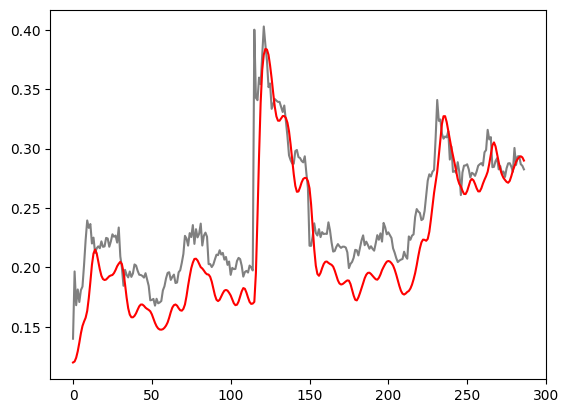

In [ ]:
plt.figure()
plt.plot(y_test, color='gray')
plt.plot(y_pred, color='red')
plt.show()

In [ ]:
# y_pred를 1차원 배열로 변환합니다.
y_pred = y_pred.reshape(-1)
# scipy의 pearsonr 함수를 사용하여 피어슨 상관계수를 계산합니다.
corr, _ = pearsonr(y_pred, y_test)
print("Pearson correlation: %.3f" % corr)

Pearson correlation: 0.916


In [ ]:
# win = 0
# los = 0
# result = 1
# leverage = 1
# fee = 0.04

# for i in range(2, len(y_test)):
#   if result_value[i-2] < result_value[i-1]:
#     result *= (1 - fee * leverage)
#     if (y_test[i] - y_test[i-1]) * (y_pred[i] - y_pred[i-1]) > 0:
#       result *= (1 + (abs(result_data[i] - result_data[i-1]) / result_data[i-1]) * leverage) * (1 - fee * leverage)
#       win += 1
#       leverage = 1
#     else:
#       result *= (1 - (abs(result_data[i] - result_data[i-1]) / result_data[i-1]) * leverage) * (1 - fee * leverage)
#       los += 1
#       leverage += 1
# rate = win / (win+los)

# win, los, str(int(rate*100))+'%', result